   Event Type  Signal Index                                             Values
0       HYP-C             0  [0.02028145329939634, 0.02028145329939634, -0....
1       HYP-C             1  [0.008377801230752449, -0.04883193127440477, -...
2       HYP-C             2  [-0.7405023248444076, 0.5205499953171703, 0.25...
3       HYP-C             3  [-1.2532503956747356, -1.44300866578148, -1.44...
4       HYP-C             4  [-0.30341213741798845, -0.3690610024039967, -0...
..        ...           ...                                                ...
80    APNEA-M            12  [0.7685385130306336, 0.7704196769056486, 0.768...
81    APNEA-M            13  [0.5099799004714098, 0.5367267985781295, 0.550...
82    APNEA-M            14  [-0.4242700426338028, -0.27840308715097917, -0...
83    APNEA-M            15  [-0.38494071530896873, -0.04838352750544326, 0...
84    APNEA-M            16  [-0.38494071530896873, -0.04838352750544326, 0...

[85 rows x 3 columns]
   Event Type  Signal Index  

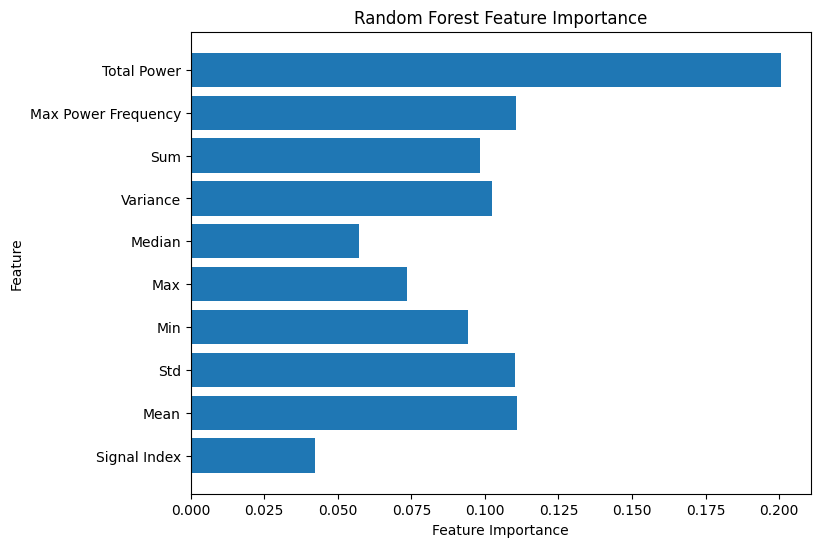

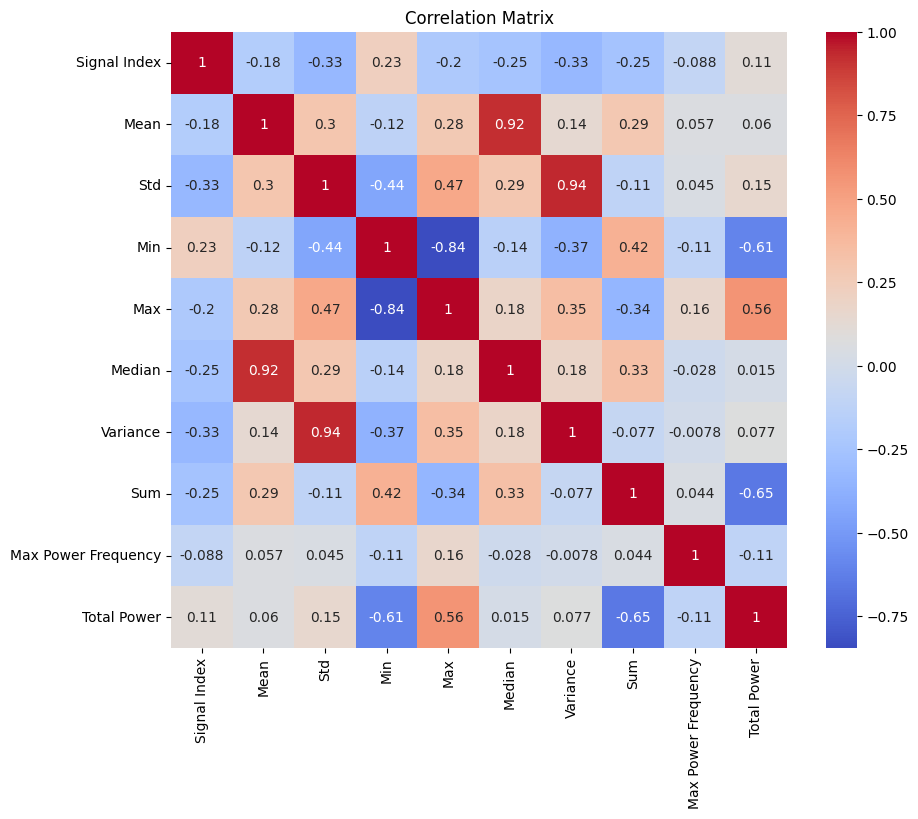

Confusion Matrix:
Labels: ['APNEA-M' 'APNEA-O' 'HYP-C' 'HYP-M' 'HYP-O']
APNEA-M 4 0 0 0 0
APNEA-O 0 1 0 2 0
HYP-C 0 0 4 0 0
HYP-M 0 1 0 2 0
HYP-O 1 0 0 0 2


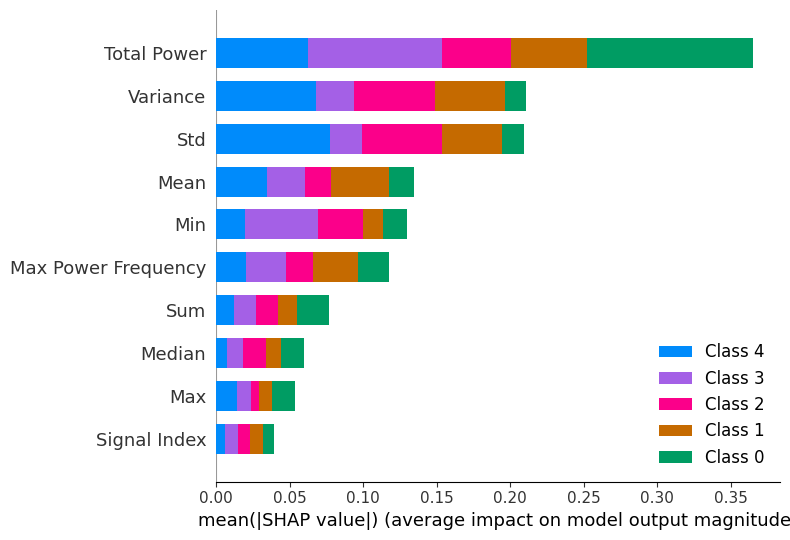

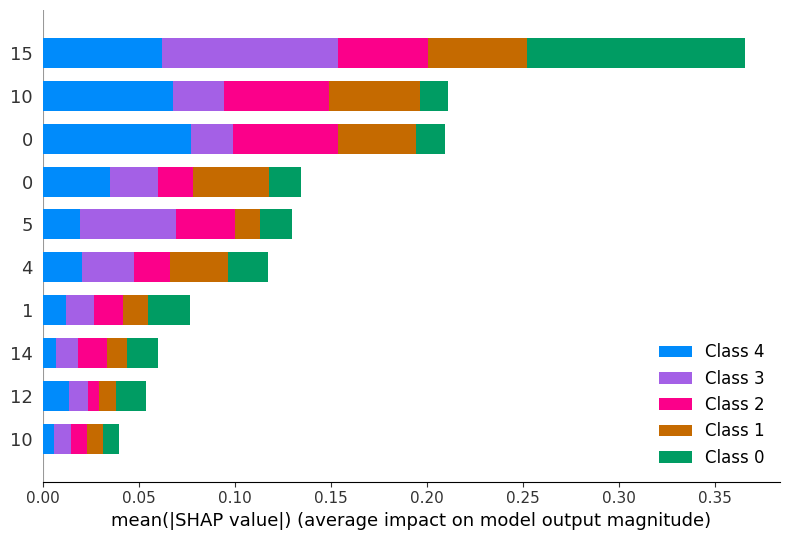

In [45]:
import pyedflib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import pyedflib
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#Variables
psg_data = []
respiratory_events = []
accumulated_signal_values=[]
respiratory_types = ['HYP-C', 'HYP-O', 'HYP-M', 'APNEA-O', 'APNEA-M', 'APNEA-C']
final_df = pd.DataFrame(columns=['RespiratoryType', 'SignalType', 'Values'])


#Methods-------------------------------------------
def FindSleepModeChanges(respevt_data):
    # Initialize variables
    previous_type = None
    type_changes = []

    # Retrive Time and Type column from respiratory_events
    timeType = respevt_data[['Time','Type']]
    
    # Iterate over the rows #for index, row in timeType.iterrows():
    for i in range(len(timeType)): 
        event_type =  timeType.loc[i, 'Type']
        # Check if the type has changed
        if event_type == 'HYP-C' or event_type == 'HYP-O' or event_type == 'HYP-M' or event_type == 'APNEA-C' or event_type == 'APNEA-O' or event_type == 'APNEA-M':
            if event_type != previous_type:
                type_changes.append((timeType.loc[i, 'Time'], event_type))
            pass
        previous_type = event_type

    # # Print the time and type changes just for test
    # for time, event_type in type_changes:
    #     print(f"Time: {time}, Type: {event_type}")
    
    return type_changes


def calculate_sample_number(signal_length, start_time, desired_time, sample_rate):
    start_t = start_time.total_seconds()
    desired_t = desired_time.total_seconds()
    
    # print('start_t:', start_t)
    # print('desired_t:', desired_t)

    t12 = datetime.datetime.strptime('12:00:00', '%H:%M:%S').time()
    t12_sec = datetime.timedelta(hours=t12.hour, minutes=t12.minute, seconds=t12.second).total_seconds()
    t24 = datetime.datetime.strptime('23:59:59', '%H:%M:%S').time()
    t24_sec = datetime.timedelta(hours=t24.hour, minutes=t24.minute, seconds=t24.second).total_seconds()

    if start_t >= t12_sec:
        start_t = start_t - t24_sec

    sample_number = int(abs(desired_t - start_t) * sample_rate)
    
#     #Just for test
#     print('start_t_edited:', start_t)
#     print('sample_rate:', sample_rate)
#     print('Calculated sample_numbern:', sample_number)
#     print('Calculated desired_t_infun:', desired_t)
    
    return sample_number, desired_t
    
    
def convert_seconds_to_time(seconds):
    time_obj = datetime.timedelta(seconds=seconds)
    time_str = str(time_obj)
    # Extract hours, minutes, and seconds from the time string
    hours, minutes, seconds = time_str.split(':')
    # Format the time as desired
    formatted_time = f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"
    return formatted_time
    

def Create_SleepMode_Data(study_number, psg_start_time, study_duration, sleep_mode_type, psg_data, ecg_data):
    
    # Variables: Create a dictionary to store arrays for each event type
    data_dict = {}
    
    for j, signal in enumerate(psg_data):
        signal_length = len(signal) #1000
        #print('signal_length', signal_length)
        psg_start_time = psg_start_time #'00:00:00' #just for test
        start_time = datetime.datetime.strptime(psg_start_time, '%H:%M:%S').time()
        start_t = datetime.timedelta(hours=start_time.hour, minutes=start_time.minute, seconds=start_time.second) #Calculate total sec

        #study_duration
        duration = datetime.timedelta(hours=study_duration)
        sample_rate = (signal_length-1) / duration.total_seconds()
        sample_number1, sample_number2 = 0, 0

        # Desired time
        for i in range(len(sleep_mode_type)): 
            
            if i < (len(sleep_mode_type)-1):
                event_type = sleep_mode_type[i][1]
                event_timeStart = sleep_mode_type[i][0]
                event_timeEnd = sleep_mode_type[i+1][0]
                #print("---------------:", event_timeStart, event_timeEnd)
                
                desired_time1 = datetime.datetime.strptime(event_timeStart, '%H:%M:%S').time() #HYP-C
                desired_t1 = datetime.timedelta(hours=desired_time1.hour, minutes=desired_time1.minute, seconds=desired_time1.second)

                desired_time2 = datetime.datetime.strptime(event_timeEnd, '%H:%M:%S').time() #HYP-O
                desired_t2 = datetime.timedelta(hours=desired_time2.hour, minutes=desired_time2.minute, seconds=desired_time2.second)

                # Calculate sample number
                sample_number1, desired_t1 = calculate_sample_number(signal_length, start_t, desired_t1, sample_rate)
                sample_number2, desired_t2 = calculate_sample_number(signal_length, start_t, desired_t2, sample_rate)
            else:
                sample_number1 = sample_number2
                sample_number2 = signal_length-1
                

            # Store the samples for each event type in the dictionary
            if event_type not in data_dict:
                data_dict[event_type] = {}

            signal_Index= j%17
            if j not in data_dict[event_type]:
                data_dict[event_type][signal_Index] = {}

            data_dict[event_type][signal_Index]['values'] = signal[sample_number1:sample_number2]

    #Just for test
    # print("\n", data_dict)
    # for key in data_dict.keys():
    #     print(key)
    
    # Reshape the nested dictionary
    reshaped_dict = {}
    for event_type, signal_data in data_dict.items():
        for signal_index, values_dict in signal_data.items():
            values = values_dict['values']
            reshaped_dict.setdefault('Event Type', []).append(event_type)
            reshaped_dict.setdefault('Signal Index', []).append(signal_index)
            reshaped_dict.setdefault('Values', []).append(values)

    # Convert the reshaped dictionary to DataFrame
    df = pd.DataFrame.from_dict(reshaped_dict)
    return df

    # Print the DataFrame
    # print(df)
    
    
    #Just for test---------------------------------------------
#     print("Sample number1:", sample_number1)
#     print("Sample number2:", sample_number2)
#     print("desired_t1:", desired_t1)
#     print("desired_t2:", desired_t2)
#     print("s1:", int(abs(desired_t1)*sample_rate))
#     print("s2:", int(abs(desired_t2)*sample_rate)-1)
    
#     # Calculate the corresponding time range
#     time_range = np.arange(desired_t1, desired_t2, 1/sample_rate) 

#     # Plot the signal range based on sample numbers
#     plt.figure(figsize=(15, 8))
#     plt.plot(np.arange(sample_number1, sample_number2), signal[sample_number1:sample_number2])
#     plt.xlabel('Sample Number')
#     plt.ylabel('Signal')
#     plt.title('Signal Range by Sample Number')
#     plt.show()

#     # Plot the signal range based on corresponding times
#     plt.figure(figsize=(15, 8))
#     plt.plot(time_range, signal[int(abs(desired_t1)*sample_rate-1):int(abs(desired_t2)*sample_rate)])
#     plt.xlabel('Time (s)')
#     plt.ylabel('Signal')
#     plt.title('Signal Range by Time')
#     plt.show()
    #Just for test---------------------------------------------
    
        
#Methods-------------------------------------------
        
        

#Read data from files------------
# Read the Excel file
subject_df = pd.read_excel('data2/SubjectDetails.xls')

# Extract my desired columns into a new DataFrame
new_subject_df = subject_df[['Study Number', 'PSG Start Time', 'Study Duration (hr)']]

# Print the new DataFrame
#print(new_subject_df)


for index, row in new_subject_df.iterrows():
    patient = row['Study Number']  #'ucddb028' 
    psg_start_time = row['PSG Start Time']  #'23:29:11'
    study_duration = row['Study Duration (hr)'] #6 
            
    #Read PSG from .rec file
    record = pyedflib.EdfReader(f'data2/{patient}.rec')
    psg_labels = record.getSignalLabels()
    num_channels = record.signals_in_file #Get the number of signals (channels)
    for i in range(num_channels):
        channel_data = record.readSignal(i)
        # Normalize the channel data
        normalized_data = (channel_data - np.mean(channel_data)) / np.std(channel_data)
        psg_data.append(normalized_data)
    record.close()
    #print(psg_data)

    #Read ECG from .edf file
    ecg_data = []
    ecg_record = pyedflib.EdfReader(f'data2/{patient}_lifecard.edf')
    num_channels = ecg_record.signals_in_file 
    for i in range(num_channels):
        channel_data = ecg_record.readSignal(i)
        # Normalize the channel data
        normalized_data = (channel_data - np.mean(channel_data)) / np.std(channel_data)
        ecg_data.append(normalized_data)
    ecg_record.close()
    #print(ecg_data)
    
    # Add ecg_data to psg_data
    psg_data.extend(ecg_data)

    #Read respiratory events from .txt file
    respevt_path = f'files_editted/{patient}_respevt.txt'
    respevt_data = pd.read_csv(respevt_path, delimiter='\t')
    respiratory_events.append(respevt_data)
    #print(respiratory_events)
    sleep_mode_type = FindSleepModeChanges(respevt_data)
    
    # Call your function for each study number
    sleep_mode_data = Create_SleepMode_Data(patient, psg_start_time, study_duration, sleep_mode_type, psg_data, ecg_data)
    print(sleep_mode_data)
    break   # Stop the loop after one iteration
    
        
 
#     #Store the output dataframe of each patient in accumulated_signal_values array
#     for event_type in sleep_mode_data['Event Type'].unique():
#         for signal_index in sleep_mode_data.loc[sleep_mode_data['Event Type'] == event_type, 'Signal Index'].unique():
#             values = sleep_mode_data.loc[(sleep_mode_data['Event Type'] == event_type) & (sleep_mode_data['Signal Index'] == signal_index), 'Values'].values
#             accumulated_signal_values.append([event_type, signal_index, np.concatenate(values)])
  
# # Create a new DataFrame from the accumulated values
# accumulated_sleep_data = pd.DataFrame(accumulated_signal_values, columns=['Event Type', 'Signal Index', 'Values'])
# print(accumulated_sleep_data)



################################################################


# from scipy import signal
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# import pandas as pd
# import numpy as np
# import shap


# # Replace this placeholder with your actual accumulated sleep data
# accumulated_sleep_data=sleep_mode_data

# print(accumulated_sleep_data)

# # Calculate statistical measures from the 'Values' arrays
# accumulated_sleep_data['Mean'] = accumulated_sleep_data['Values'].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) and len(x) > 0 else np.nan)
# accumulated_sleep_data['Std'] = accumulated_sleep_data['Values'].apply(lambda x: np.std(x) if isinstance(x, np.ndarray) and len(x) > 0 else np.nan)
# accumulated_sleep_data['Min'] = accumulated_sleep_data['Values'].apply(lambda x: np.min(x) if isinstance(x, np.ndarray) and len(x) > 0 else np.nan)
# accumulated_sleep_data['Max'] = accumulated_sleep_data['Values'].apply(lambda x: np.max(x) if isinstance(x, np.ndarray) and len(x) > 0 else np.nan)

# # Calculate frequency-domain features using power spectral density estimation
# for index,row in accumulated_sleep_data.iterrows():
#     raw = row['Values']
#     fft_data = np.array([])  # Initialize an empty array for FFT data

#     # Handle zero-dimensional arrays separately
#     # if np.ndim(raw) == 0:
#     #     fft_data = np.abs(np.fft.fft(raw))
#     # else:
#     #     for arr in raw:
#     #         if isinstance(arr, np.ndarray) and len(arr) > 0:  # Skip empty arrays
#                 # fft_data = np.concatenate((fft_data, np.abs(np.fft.fft(arr))), axis=None)
#     fft_data = np.abs(np.fft.fft(raw))            
#     print("***",len(fft_data))

#     if len(fft_data) > 0:  # Check if fft_data is not empty
#         # Calculate frequency axis
#         n = len(fft_data)
#         dt = 1 / 256  # Sampling interval
#         freqs = np.fft.fftfreq(n, dt)[:n//2+1]

#         # Calculate power spectral density
#         psd = np.square(fft_data[:n//2+1]) / (n * dt)

#         # Find the frequency with maximum power
#         max_power_freq = freqs[np.argmax(psd)]

#         # Calculate total power
#         total_power = np.sum(psd)

#         # Add frequency-domain features to the accumulated sleep data
#         accumulated_sleep_data.loc[index, 'Max Power Frequency'] = max_power_freq
#         accumulated_sleep_data.loc[index, 'Total Power'] = total_power
#     else:
#         # If fft_data is empty, set NaN values for frequency-domain features
#         print("ömadam inja")
#         accumulated_sleep_data.loc[index, 'Max Power Frequency'] = np.nan
#         accumulated_sleep_data.loc[index, 'Total Power'] = np.nan

# # Drop rows with NaN values
# accumulated_sleep_data.dropna(inplace=True)
# print(accumulated_sleep_data)
# # Select the input features (X) and the target variable (y)
# X = accumulated_sleep_data[['Signal Index', 'Mean', 'Std', 'Min', 'Max', 'Max Power Frequency', 'Total Power']]
# y = accumulated_sleep_data['Event Type']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Drop rows with NaN values from the training set
# train_indices = X_train.index.dropna()
# X_train = X_train.loc[train_indices]
# y_train = y_train.loc[train_indices]


# # Initialize and train the Random Forest classifier
# classifier = RandomForestClassifier()
# classifier.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = classifier.predict(X_test)

# # Evaluate the performance of the classifier
# print(classification_report(y_test, y_pred))

# # Create the SHAP explainer
# explainer = shap.Explainer(classifier, X_train)

# # Calculate SHAP values
# shap_values = explainer.shap_values(X_test, check_additivity=False)

# # Interpret the SHAP values
# shap.summary_plot(shap_values, X_test)



#####################################

from scipy import signal
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns

import shap

# Replace this placeholder with your actual accumulated sleep data
accumulated_sleep_data = sleep_mode_data

print(accumulated_sleep_data)

# Calculate statistical measures from the 'Values' arrays
accumulated_sleep_data['Mean'] = accumulated_sleep_data['Values'].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) and len(x) > 0 else np.nan)
accumulated_sleep_data['Std'] = accumulated_sleep_data['Values'].apply(lambda x: np.std(x) if isinstance(x, np.ndarray) and len(x) > 0 else np.nan)
accumulated_sleep_data['Min'] = accumulated_sleep_data['Values'].apply(lambda x: np.min(x) if isinstance(x, np.ndarray) and len(x) > 0 else np.nan)
accumulated_sleep_data['Max'] = accumulated_sleep_data['Values'].apply(lambda x: np.max(x) if isinstance(x, np.ndarray) and len(x) > 0 else np.nan)
accumulated_sleep_data['Median'] = accumulated_sleep_data['Values'].apply(lambda x: np.median(x) if isinstance(x, np.ndarray) and len(x) > 0 else np.nan)
accumulated_sleep_data['Variance'] = accumulated_sleep_data['Values'].apply(lambda x: np.var(x) if isinstance(x, np.ndarray) and len(x) > 0 else np.nan)
accumulated_sleep_data['Sum'] = accumulated_sleep_data['Values'].apply(lambda x: np.sum(x) if isinstance(x, np.ndarray) and len(x) > 0 else np.nan)
#accumulated_sleep_data['Square Root'] = accumulated_sleep_data['Values'].apply(lambda x: np.sqrt(x) if isinstance(x, np.ndarray) and len(x) > 0 else np.nan)

# Calculate frequency-domain features using power spectral density estimation
for index,row in accumulated_sleep_data.iterrows():
    raw = row['Values']
    fft_data = np.array([])  # Initialize an empty array for FFT data

    # Handle zero-dimensional arrays separately
    # if np.ndim(raw) == 0:
    #     fft_data = np.abs(np.fft.fft(raw))
    # else:
    #     for arr in raw:
    #         if isinstance(arr, np.ndarray) and len(arr) > 0:  # Skip empty arrays
                # fft_data = np.concatenate((fft_data, np.abs(np.fft.fft(arr))), axis=None)
    fft_data = np.abs(np.fft.fft(raw))            

    if len(fft_data) > 0:  # Check if fft_data is not empty
        # Calculate frequency axis
        n = len(fft_data)
        dt = 1 / 256  # Sampling interval
        freqs = np.fft.fftfreq(n, dt)[:n//2+1]

        # Calculate power spectral density
        psd = np.square(fft_data[:n//2+1]) / (n * dt)

        # Find the frequency with maximum power
        max_power_freq = freqs[np.argmax(psd)]

        # Calculate total power
        total_power = np.sum(psd)

        # Add frequency-domain features to the accumulated sleep data
        accumulated_sleep_data.loc[index, 'Max Power Frequency'] = max_power_freq
        accumulated_sleep_data.loc[index, 'Total Power'] = total_power
    else:
        # If fft_data is empty, set NaN values for frequency-domain features
        print("ömadam inja")
        accumulated_sleep_data.loc[index, 'Max Power Frequency'] = np.nan
        accumulated_sleep_data.loc[index, 'Total Power'] = np.nan

# Drop rows with NaN values
accumulated_sleep_data.dropna(inplace=True)

# Select the input features (X) and the target variable (y)
X = accumulated_sleep_data[['Signal Index', 'Mean', 'Std', 'Min', 'Max', 'Median', 'Variance', 'Sum', 'Max Power Frequency', 'Total Power']]
y = accumulated_sleep_data['Event Type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop rows with NaN values from the training set
train_indices = X_train.index.dropna()
X_train = X_train.loc[train_indices]
y_train = y_train.loc[train_indices]

# Initialize and train the Random Forest classifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the performance of the classifier
print("Test Set Performance:")
print(classification_report(y_test, y_pred))





importance = classifier.feature_importances_
feature_names = X.columns
plt.figure(figsize=(8, 6))
plt.barh(feature_names, importance)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.show()



# # Combine the features (X) and labels (y) into a single DataFrame
# data = pd.concat([X, y], axis=1)

# # Calculate the correlation matrix
# correlation_matrix = data.corr()

# # Plot the correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
# plt.title("Correlation Matrix")
# plt.show()


# Calculate the correlation matrix
correlation_matrix = X.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()


from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix table
labels = classifier.classes_
print("Confusion Matrix:")
print("Labels:", labels)
for i in range(len(labels)):
    row = " ".join([str(count) for count in cm[i]])
    print(labels[i], row)


# Create the SHAP explainer
explainer = shap.Explainer(classifier, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Interpret the SHAP values
shap.summary_plot(shap_values, X_test)



# Create the SHAP explainer
explainer = shap.Explainer(classifier, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Reset the index of X_test
X_test_reset = X_test.reset_index(drop=True)

# Convert X_test_reset to a DataFrame for easy column selection
X_test_df = pd.DataFrame(X_test_reset, columns=X.columns)

# Plot the SHAP values for the 'Signal Index' feature
shap.summary_plot(shap_values, X_test_df['Signal Index'])



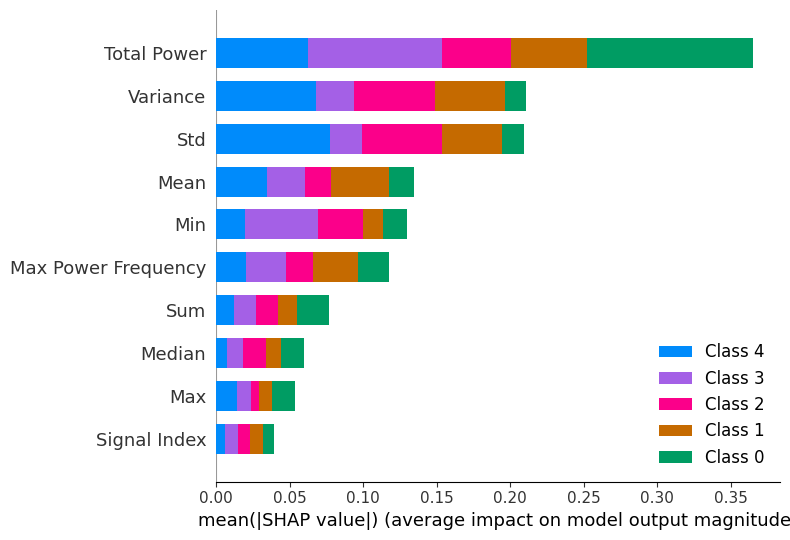

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

In [51]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Create the SHAP explainer
explainer = shap.Explainer(classifier, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Waterfall plot
if isinstance(shap_values[1], np.ndarray):
    shap.waterfall_plot(shap_values[1][0], max_display=10)
else:
    shap.waterfall_plot(shap_values[1], max_display=10)



# # Beeswarm plot
# shap.beeswarm_plot(shap_values[1], max_display=10)

# Heatmap plot
# shap.summary_plot(shap_values, X_test, plot_type="heatmap")

# Bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

plt.show()


In [44]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Create the SHAP explainer
explainer = shap.Explainer(classifier, X_train)

# Calculate SHAP values
shap_values = explainer(X_test)

# Waterfall plot
if len(shap_values.shape) > 1:
    feature_names = X_test.columns.tolist()
    shap.waterfall_plot(explainer.expected_value[1], shap_values[1][0], max_display=10, show=False)
    plt.xticks(range(len(feature_names)), feature_names)
else:
    feature_names = X_test.columns.tolist()
    shap.waterfall_plot(explainer.expected_value[1], shap_values[1], max_display=10, show=False)
    plt.xticks(range(len(feature_names)), feature_names)

plt.show()


TypeError: waterfall() got multiple values for argument 'max_display'

In [6]:
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Create the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Print the confusion matrix with precision and recall values
labels = np.unique(y_test)
precision_recall_matrix = np.zeros((len(labels), 2))
for i, label in enumerate(labels):
    TP = confusion[i, i]
    FP = np.sum(confusion[:, i]) - TP
    FN = np.sum(confusion[i, :]) - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    precision_recall_matrix[i, 0] = precision
    precision_recall_matrix[i, 1] = recall

print("Precision and Recall Confusion Matrix:")
print(confusion)
print("Precision and Recall:")
print(precision_recall_matrix)


Precision and Recall Confusion Matrix:
[[4 0 0 0 0]
 [0 1 0 2 0]
 [0 0 4 0 0]
 [0 1 0 2 0]
 [1 0 0 0 2]]
Precision and Recall:
[[0.8        1.        ]
 [0.5        0.33333333]
 [1.         1.        ]
 [0.5        0.66666667]
 [1.         0.66666667]]


In [8]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Calculate the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Display the accuracy table
accuracy_table = report_df[['precision', 'recall', 'f1-score', 'support']]
accuracy_table.loc['accuracy'] = report_df.loc['accuracy']
print("Accuracy Table:")
print(accuracy_table)


Accuracy Table:
              precision    recall  f1-score    support
APNEA-M        0.800000  1.000000  0.888889   4.000000
APNEA-O        0.500000  0.333333  0.400000   3.000000
HYP-C          1.000000  1.000000  1.000000   4.000000
HYP-M          0.500000  0.666667  0.571429   3.000000
HYP-O          1.000000  0.666667  0.800000   3.000000
accuracy       0.764706  0.764706  0.764706   0.764706
macro avg      0.760000  0.733333  0.732063  17.000000
weighted avg   0.776471  0.764706  0.757049  17.000000


<Figure size 800x600 with 0 Axes>

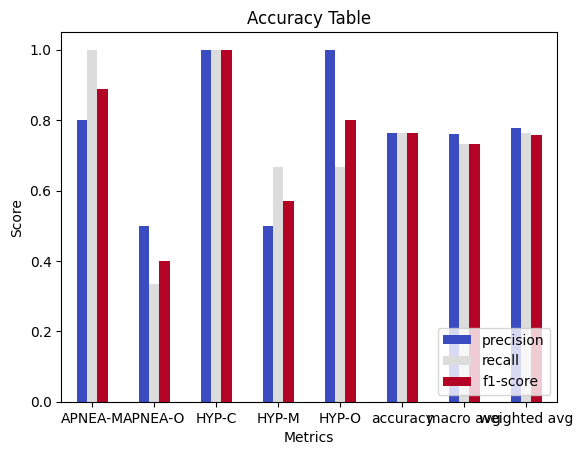

In [9]:
import matplotlib.pyplot as plt

# Plot the accuracy table
plt.figure(figsize=(8, 6))
accuracy_table_plot = accuracy_table.drop('support', axis=1)  # Drop the 'support' column
accuracy_table_plot.plot(kind='bar', cmap='coolwarm')
plt.title('Accuracy Table')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()


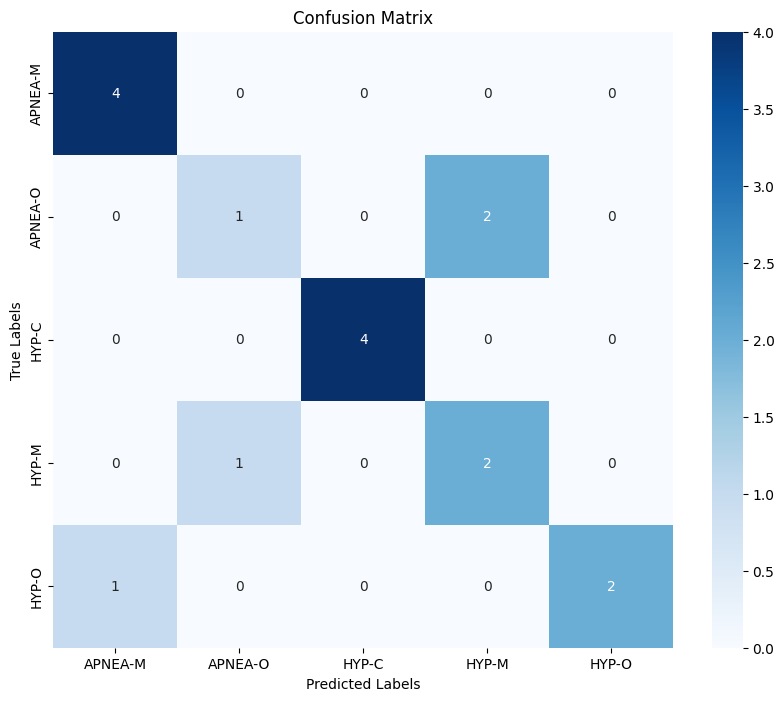

Accuracy Table:
         Accuracy
Metrics          
Overall  0.764706


In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the unique labels
labels = np.unique(np.concatenate((y_test, y_pred)))

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Create a DataFrame for accuracy table
accuracy_df = pd.DataFrame({'Accuracy': [accuracy]}, index=['Overall'])
accuracy_df.index.name = 'Metrics'

# Display the accuracy table
print("Accuracy Table:")
print(accuracy_df)


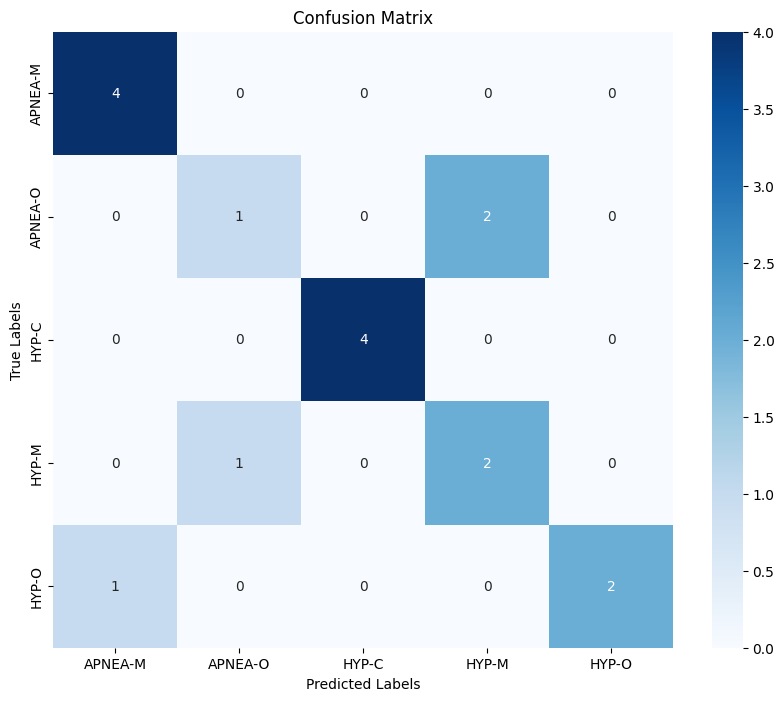

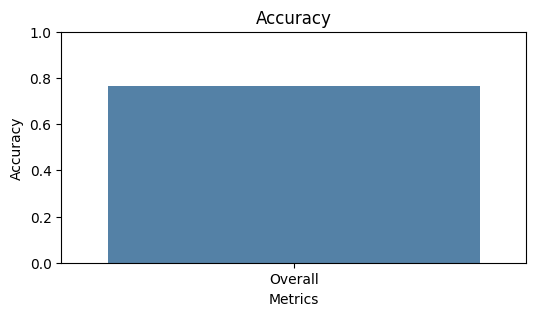

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the unique labels
labels = np.unique(np.concatenate((y_test, y_pred)))

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Create a DataFrame for accuracy table
accuracy_df = pd.DataFrame({'Accuracy': [accuracy]}, index=['Overall'])
accuracy_df.index.name = 'Metrics'

# Plot the accuracy table
plt.figure(figsize=(6, 3))
sns.barplot(data=accuracy_df, x=accuracy_df.index, y='Accuracy', color='steelblue')
plt.title('Accuracy')
plt.xlabel('Metrics')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


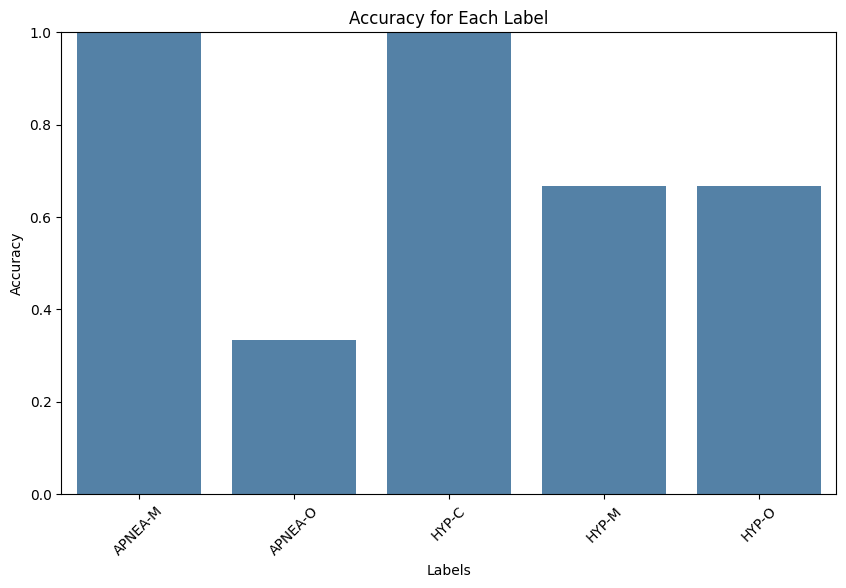

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the unique labels
labels = np.unique(np.concatenate((y_test, y_pred)))

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Calculate the accuracy for each label
accuracy_per_label = cm.diagonal() / cm.sum(axis=1)

# Create a DataFrame for accuracy table
accuracy_df = pd.DataFrame({'Accuracy': accuracy_per_label}, index=labels)
accuracy_df.index.name = 'Labels'

# Plot the accuracy table
plt.figure(figsize=(10, 6))
sns.barplot(data=accuracy_df, x=accuracy_df.index, y='Accuracy', color='steelblue')
plt.title('Accuracy for Each Label')
plt.xlabel('Labels')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()


    Signal Index      Mean       Std        Min        Max
0              0 -0.005759  1.676302  -7.403895   7.111358
1              1 -0.063394  1.612098  -7.007616   6.639506
2              2  0.007746  1.746598 -22.009226  21.635487
3              3  0.013615  1.387648 -10.285744  10.306823
4              4 -0.062661  1.666254  -8.034828   6.614968
..           ...       ...       ...        ...        ...
80            12  0.473661  0.423992  -2.340085   0.775123
81            13 -0.408131  0.817110  -1.830374   5.060296
82            14 -0.020204  1.046251 -24.881296  14.247515
83            15 -0.032721  1.281869 -19.204097  19.060586
84            16 -0.032721  1.281869 -19.204097  19.060586

[85 rows x 5 columns]
              precision    recall  f1-score   support

     APNEA-M       0.75      0.75      0.75         4
     APNEA-O       0.50      0.33      0.40         3
       HYP-C       0.80      1.00      0.89         4
       HYP-M       0.67      0.67      0.67         

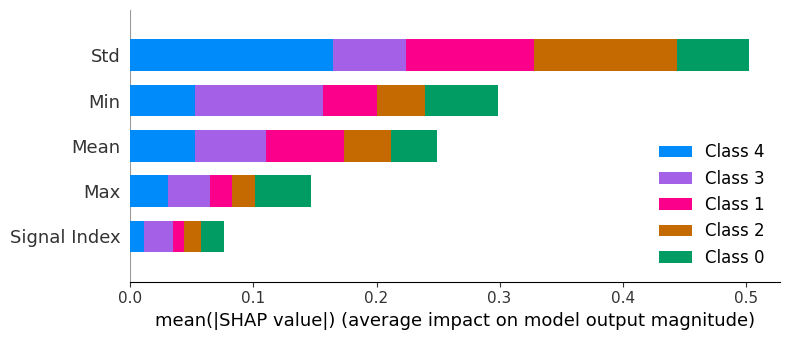

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import shap

accumulated_sleep_data=sleep_mode_data
#print(accumulated_sleep_data)
# Calculate statistical measures from the 'Values' arrays
accumulated_sleep_data['Mean'] = accumulated_sleep_data['Values'].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)
accumulated_sleep_data['Std'] = accumulated_sleep_data['Values'].apply(lambda x: np.std(x) if len(x) > 0 else np.nan)
accumulated_sleep_data['Min'] = accumulated_sleep_data['Values'].apply(lambda x: np.min(x) if len(x) > 0 else np.nan)
accumulated_sleep_data['Max'] = accumulated_sleep_data['Values'].apply(lambda x: np.max(x) if len(x) > 0 else np.nan)
#accumulated_sleep_data['skew'] = accumulated_sleep_data['Values'].apply(lambda x: np.skew(x) if len(x) > 0 else np.nan)

# Drop rows with NaN values
accumulated_sleep_data.dropna(inplace=True)

# Select the input features (X) and the target variable (y)
X = accumulated_sleep_data[['Signal Index', 'Mean', 'Std', 'Min', 'Max']]
#print(X.shape())
print(X)
y = accumulated_sleep_data['Event Type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the performance of the classifier
print(classification_report(y_test, y_pred))

print(X_train.shape)
print(X_test.shape)

# Create the SHAP explainer
explainer = shap.Explainer(classifier, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Interpret the SHAP values
shap.summary_plot(shap_values, X_test)

In [ ]:
from scipy import signal
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import shap

# Replace 'raw.info['sfreq']' with your actual sampling frequency

# Replace this placeholder with your actual accumulated sleep data
accumulated_sleep_data = sleep_mode_data
raw = accumulated_sleep_data['Values']
# Calculate frequency-domain features using power spectral density estimation
from scipy.fft import fft

# Calculate FFT on the raw data
#fft_data = np.abs(fft(raw))  # Compute the absolute value of the FFT coefficients
fft_data = np.abs(fft(np.concatenate(raw)))

# Calculate frequency axis
n = len(raw[0])
print("n is",n)
dt = 1 / 256  # Sampling interval
freqs = np.fft.fftfreq(n, dt)[:n//2+1]

# Calculate power spectral density
psd = np.square(fft_data[:n//2+1]) / (n * dt)

# Find the frequency with maximum power
max_power_freq = freqs[np.argmax(psd)]

# Calculate total power
total_power = np.sum(psd)
# Add frequency-domain features to the accumulated sleep data
accumulated_sleep_data['Max Power Frequency'] = max_power_freq
accumulated_sleep_data['Total Power'] = total_power

# Calculate statistical measures from the 'Values' arrays
accumulated_sleep_data['Mean'] = accumulated_sleep_data['Values'].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)
accumulated_sleep_data['Std'] = accumulated_sleep_data['Values'].apply(lambda x: np.std(x) if len(x) > 0 else np.nan)
accumulated_sleep_data['Min'] = accumulated_sleep_data['Values'].apply(lambda x: np.min(x) if len(x) > 0 else np.nan)
accumulated_sleep_data['Max'] = accumulated_sleep_data['Values'].apply(lambda x: np.max(x) if len(x) > 0 else np.nan)

# Drop rows with NaN values
accumulated_sleep_data.dropna(inplace=True)

# Select the input features (X) and the target variable (y)
X = accumulated_sleep_data[['Signal Index', 'Mean', 'Std', 'Min', 'Max', 'Max Power Frequency', 'Total Power']]
print("shape of x",X.shape)
print("x :",X)
y = accumulated_sleep_data['Event Type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the performance of the classifier
print(classification_report(y_test, y_pred))

# Create the SHAP explainer
explainer = shap.Explainer(classifier, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Interpret the SHAP values
shap.summary_plot(shap_values, X_test)


In [ ]:
import pandas as pd

# Replace this placeholder with the actual structure and format of accumulated_sleep_data
# Example: accumulated_sleep_data = pd.DataFrame(...)
accumulated_sleep_data = sleep_mode_data

# Display a sample of accumulated_sleep_data
print(accumulated_sleep_data.head())

# Replace this placeholder with the actual shape of the raw data
# Example: raw_shape = (100, 1) if raw is a 1D array with 100 elements
raw_shape = accumulated_sleep_data

# Print the shape of the raw data
print(f"Shape of raw data: {raw_shape}")

# Replace this placeholder with the expected format of the raw data
# Example: expected_raw_format = "time-series" if raw data is in a time-series format
expected_raw_format = ...

# Print the expected format of the raw data
print(f"Expected format of raw data: {expected_raw_format}")


In [ ]:
print(accumulated_sleep_data.head())  # Display the first few rows
print(accumulated_sleep_data.info())  # Print the summary information
print(accumulated_sleep_data.shape)  # Print the dimensions of the DataFrame